In [1]:

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


In [3]:
# load a model after trained
grating_orientation_discrimination=torch.load('/gdrive/My Drive/best_vgg_model.pkl')  #,map_location=torch.device('cpu')

input_size = 224
# to the ImageFolder structure
data_dir = "/gdrive/My Drive/gratings/"

data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# 提取不同层输出的 主要代码
class LayerActivations:
    features = None
 
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
 
    def hook_fn(self, module, input, output):
        self.features = output.cpu()
 
    def remove(self):
        self.hook.remove()

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

foldername = '/gdrive/My Drive/Results/'
# os.makedirs(foldername)
test_dataset_name = ['testdistractor', 'testlarge', 'testsurr', 'testcensurr', 'testcensurr_lc', 'testcensurr_gap']

In [18]:
print(len(test_dataset_name[1]))

9


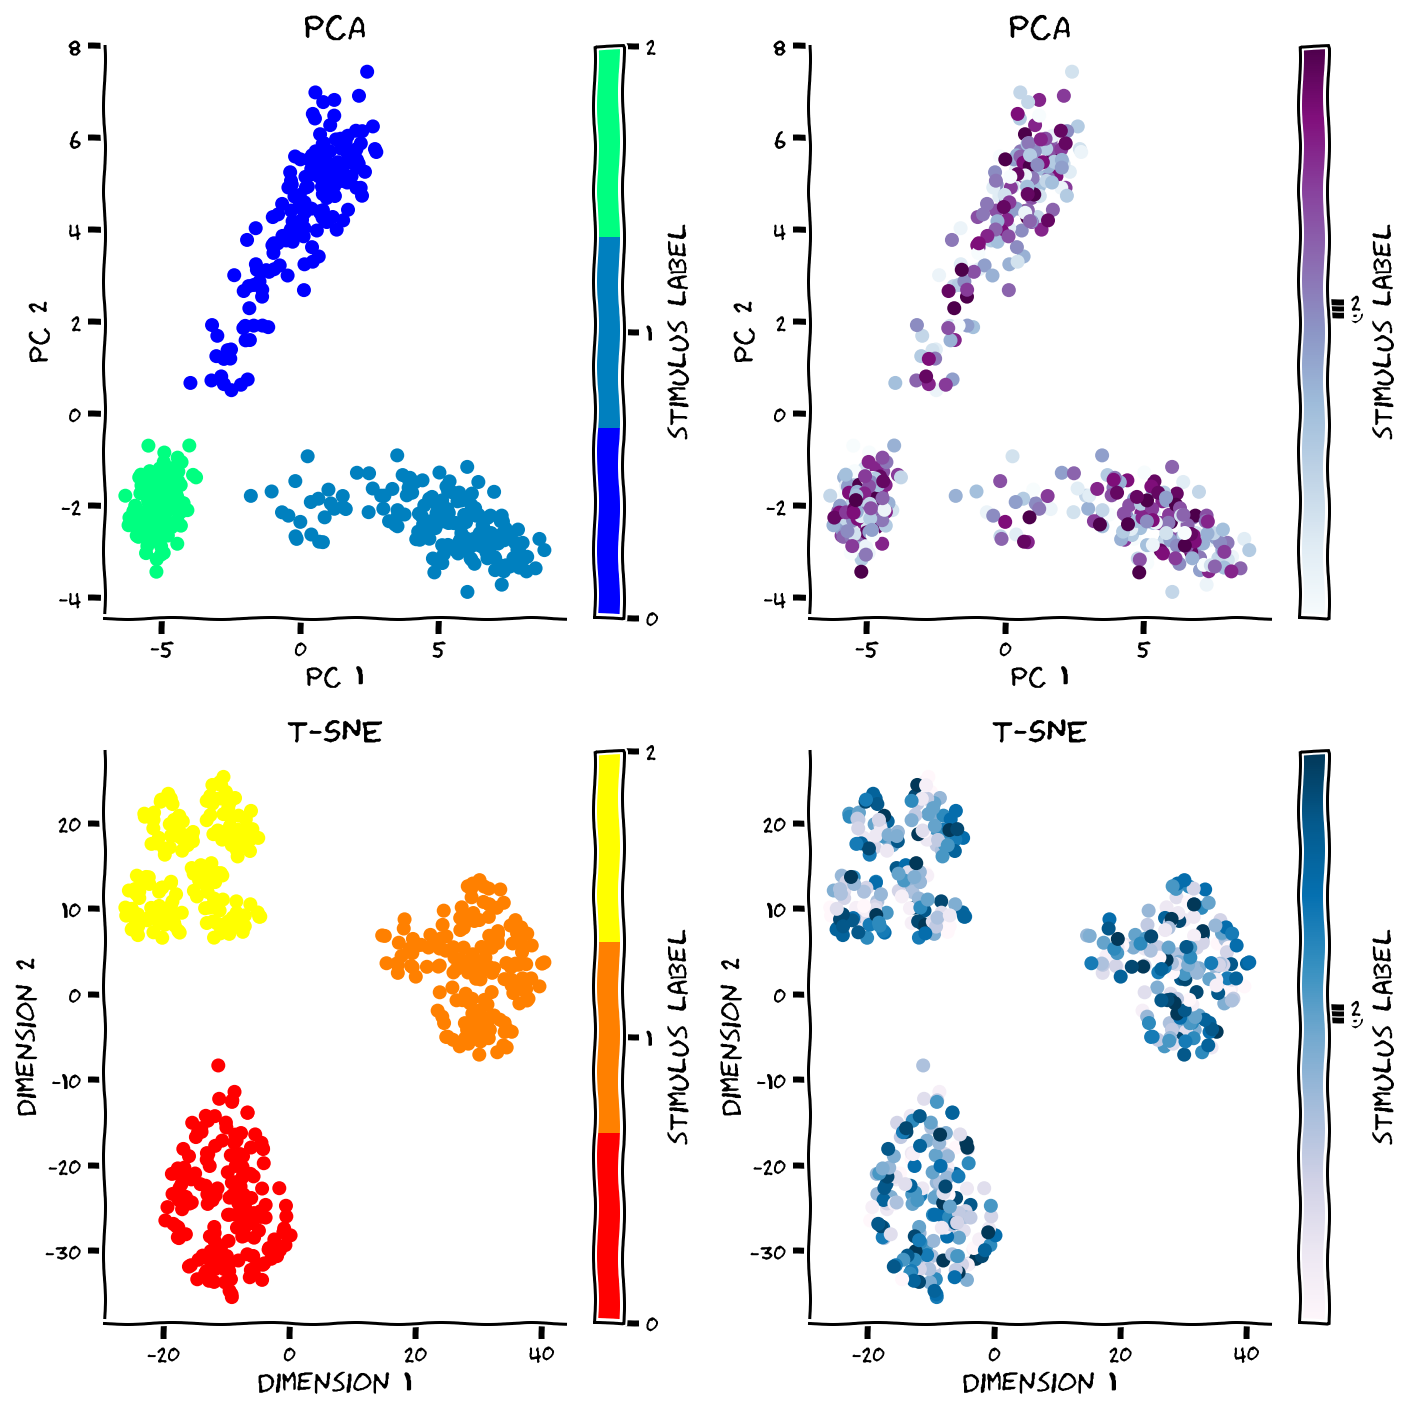

In [ ]:
foldername = '/gdrive/My Drive/Results/'

for ii in range(6):

    test_dataset = datasets.ImageFolder(os.path.join(data_dir, test_dataset_name[ii]), data_transform)
    input_batch = torch.cat([test_dataset[k][0].unsqueeze(0) for k in range(len(test_dataset))], dim=0)
    labels = np.array([test_dataset[k][1] for k in range(len(test_dataset))])
    ### get inducer ori
    inducer_ori = np.zeros(len(test_dataset))
    for jj in range(len(test_dataset)):
        idx_s = test_dataset.imgs[jj][0].find('_orio')
        idx_e = test_dataset.imgs[jj][0].find('_w')
        if idx_s>0 and idx_e>0:
            inducer_ori[jj] = int(test_dataset.imgs[jj][0][idx_s+5:idx_e])

    # print(grating_orientation_discrimination.features)
    # print(grating_orientation_discrimination.classifier)
    conv_out = LayerActivations(grating_orientation_discrimination.classifier, 1)  # 提出第 一个卷积层的输出 

    # ------------ run 
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        grating_orientation_discrimination.to('cuda')
        
    with torch.no_grad():
        output = grating_orientation_discrimination(input_batch)

    conv_out.remove() 

    fc_resp = conv_out.features  # act 即 第0层输出的特征
    # -------------- DR
    # First do PCA to reduce dimensionality to 200 dimensions so that tSNE is faster
    resp_lowd = PCA(n_components=2).fit_transform(fc_resp)
    # Then do tSNE to reduce dimensionality to 2 dimensions
    resp_tsne = TSNE(n_components=2).fit_transform(fc_resp)
    
    with plt.xkcd():
        fig = plt.figure(figsize=(10.0, 10.0))

        ax0 = fig.add_subplot(2, 2, 1)
        ax1 = fig.add_subplot(2, 2, 3)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)
        # Plot dimensionality-reduced population responses
        # on 2D axes, with each point colored by stimulus label
        cmap = plt.cm.get_cmap('winter',3)
        scat = ax0.scatter(resp_lowd[:, 0], resp_lowd[:, 1], c=labels,cmap=cmap)# 
        
        cbar = plt.colorbar(scat, ax=ax0, label='stimulus label',ticks=[0, 1, 2])
        ax0.set_xlabel('PC 1')
        ax0.set_ylabel('PC 2')  
        ax0.set_title('PCA')
        # ax.set_yticks([])

        # on 2D axes, with each point colored by stimulus label
        cmap = plt.cm.get_cmap('autumn',3)
        scat = ax1.scatter(resp_tsne[:, 0], resp_tsne[:, 1], c=labels,cmap=cmap)# 
        
        cbar = plt.colorbar(scat, ax=ax1, label='stimulus label',ticks=[0, 1, 2])
        ax1.set_xlabel('Dimension 1')
        ax1.set_ylabel('Dimension 2')  
        ax1.set_title('t-SNE')
        # ax.set_yticks([])

        # Plot dimensionality-reduced population responses
        # on 2D axes, with each point colored by stimulus label
        cmap = plt.cm.get_cmap('BuPu')
        scat = ax2.scatter(resp_lowd[:, 0], resp_lowd[:, 1], c=inducer_ori,cmap=cmap)# 
        
        cbar = plt.colorbar(scat, ax=ax2, label='Inducer Orientation')
        ax2.set_xlabel('PC 1')
        ax2.set_ylabel('PC 2')  
        ax2.set_title('PCA')
        # ax.set_yticks([])

        # on 2D axes, with each point colored by stimulus label
        cmap = plt.cm.get_cmap('PuBu')
        scat = ax3.scatter(resp_tsne[:, 0], resp_tsne[:, 1], c=inducer_ori,cmap=cmap)# 
        
        cbar = plt.colorbar(scat, ax=ax3, label='Inducer Orientation')
        ax3.set_xlabel('Dimension 1')
        ax3.set_ylabel('Dimension 2')  
        ax3.set_title('t-SNE')
        # ax.set_yticks([])

        plt.tight_layout()
        plt.savefig(os.path.join(foldername, test_dataset_name[ii]),format='png')
        plt.show()
        

In [ ]:
def get_hidden_activity(net, stimuli, layer_labels):
  """Retrieve internal representations of network

  Args:
    net (nn.Module): deep network
    stimuli (torch.Tensor): p x 48 x 64 tensor with stimuli for which to 
      compute and retrieve internal representations
    layer_labels (list): list of strings with labels of each layer for which
      to return its internal representations

  Returns:
    dict: internal representations at each layer of the network, in
      numpy arrays. The keys of this dict are the strings in layer_labels.

  """

  # Placeholder
  hidden_activity = {}

  # Attach 'hooks' to each layer of the network to store hidden
  # representations in hidden_activity
  def hook(module, input, output):
    module_label = list(net._modules.keys())[np.argwhere([module == m for m in net._modules.values()])[0, 0]]
    if module_label in layer_labels:  # ignore output layer
      hidden_activity[module_label] = output.view(stimuli.shape[0], -1).detach().numpy()
  hooks = [layer.register_forward_hook(hook) for layer in net.children()]

  # Run stimuli through the network
  pred = net(stimuli)
  
  # Remove the hooks
  [h.remove() for h in hooks]

  return hidden_activity